In [1]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
pwd

'/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master'

In [3]:
class ConfigClass():
    train_dir = '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/'
    test_dir = '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/testing/'   
    train_batch_size = 64
    train_num_epochs = 100

In [4]:
class SiameseDataset(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)
    
    
    
    
    

In [5]:
import os

train_dir = ConfigClass.train_dir
if os.path.isdir(train_dir):
    print(f"The train_dir '{train_dir}' exists and is accessible")
else:
    print(f"The train_dir '{train_dir}' does not exist or is not accessible")

The train_dir '/Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/' exists and is accessible


In [6]:
try:
    SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)
except Exception as e:
    print("An error occurred while accessing the image folder: ", e)

An error occurred while accessing the image folder:  name 'image_folder' is not defined


In [7]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir)
siamese_dataset = SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

In [8]:
print("Image Folder: ", image_folder)
print("Siamese Dataset: ", siamese_dataset)

Image Folder:  Dataset ImageFolder
    Number of datapoints: 740
    Root location: /Users/mounikaganjikunta/Desktop/Spring 2023/Project/Face-Similarity-Siamese-Network-master/data/faces/training/
Siamese Dataset:  <__main__.SiameseDataset object at 0x7fa5ec295460>


In [9]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

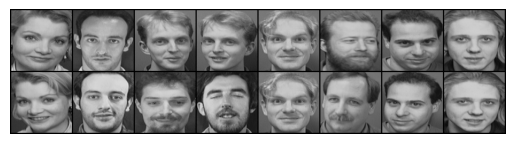

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [10]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2

In [12]:
import torch.nn.functional as F

class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        
        distance = F.mse_loss(output1, output2, reduction='none').sum(1, keepdim=True)
        
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - torch.sqrt(distance), min=0.0), 2))
        
        return contrastive_loss

In [13]:
print(torch.version.cuda)

None


In [14]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cuXX/torch_stable.html



SyntaxError: invalid syntax (3878635041.py, line 1)

In [15]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=ConfigClass.train_batch_size)
model = SiameseNetwork().cpu()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 5.407976150512695
Epoch: 1 	 Loss: 8.258512496948242
Epoch: 2 	 Loss: 7.2886786460876465
Epoch: 3 	 Loss: 13.329903602600098
Epoch: 4 	 Loss: 4.187374114990234
Epoch: 5 	 Loss: 13.013751983642578
Epoch: 6 	 Loss: 7.450080394744873
Epoch: 7 	 Loss: 4.721749305725098
Epoch: 8 	 Loss: 0.6463518142700195
Epoch: 9 	 Loss: 0.8908258676528931
Epoch: 10 	 Loss: 0.24845103919506073
Epoch: 11 	 Loss: 0.1581384837627411
Epoch: 12 	 Loss: 0.10324621945619583
Epoch: 13 	 Loss: 0.05736518278717995
Epoch: 14 	 Loss: 0.07307258248329163
Epoch: 15 	 Loss: 0.11481503397226334
Epoch: 16 	 Loss: 0.049318134784698486
Epoch: 17 	 Loss: 0.03797345608472824
Epoch: 18 	 Loss: 0.060753874480724335
Epoch: 19 	 Loss: 0.04827966168522835
Epoch: 20 	 Loss: 0.03475143760442734
Epoch: 21 	 Loss: 0.031420301645994186
Epoch: 22 	 Loss: 0.0400906503200531
Epoch: 23 	 Loss: 0.04402482137084007
Epoch: 24 	 Loss: 0.046230997890233994
Epoch: 25 	 Loss: 0.031142421066761017
Epoch: 26 	 Loss: 0.02916103601455

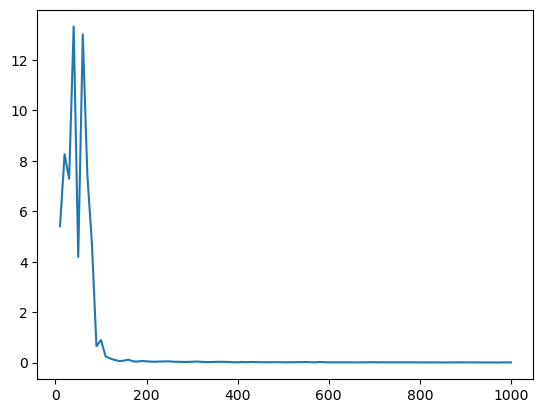

In [16]:
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1.cpu(), input2.cpu(), label.cpu()
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
            
show_plot(counter, loss_history)

Iteration 1


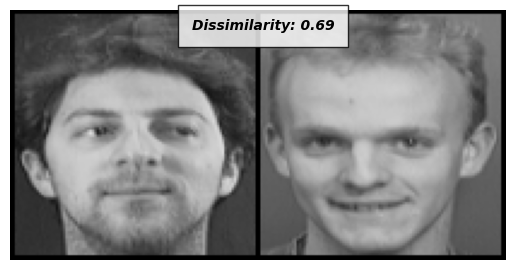

Iteration 2


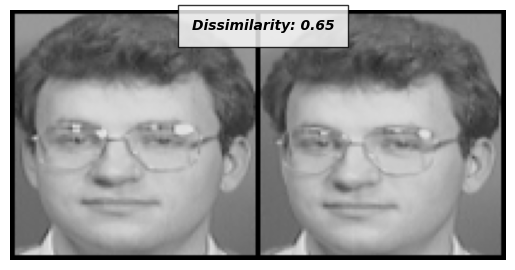

Iteration 3


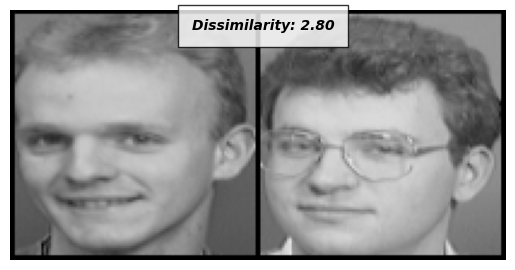

Iteration 4


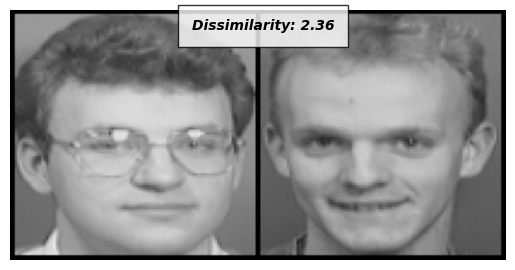

Iteration 5


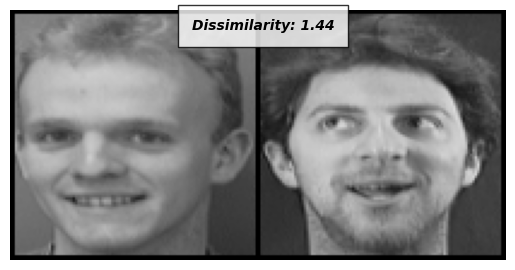

Iteration 6


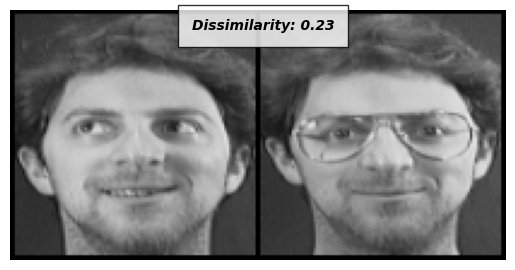

Iteration 7


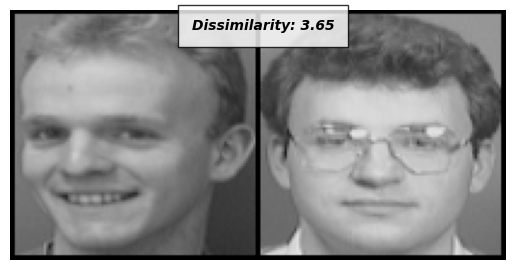

Iteration 8


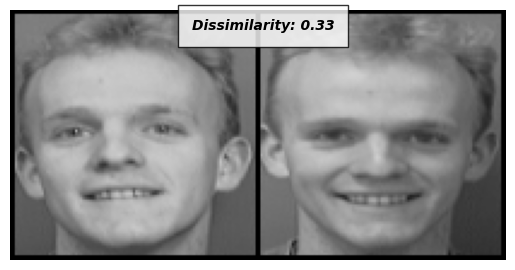

Iteration 9


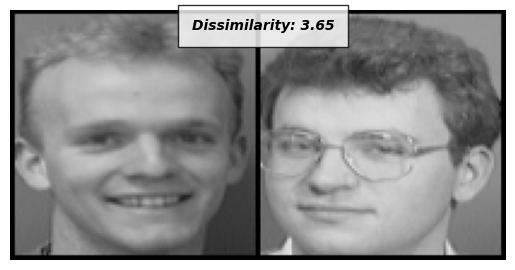

Iteration 10


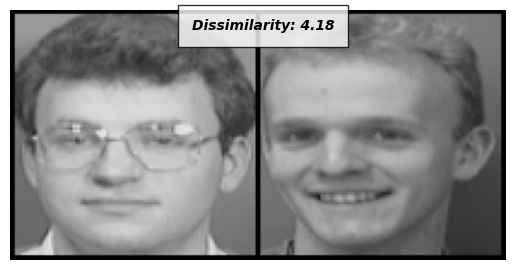

Accuracy: 0.80

Confusion Matrix:
 [[7 1]
 [1 1]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.50      0.50      0.50         2

    accuracy                           0.80        10
   macro avg       0.69      0.69      0.69        10
weighted avg       0.80      0.80      0.80        10



In [62]:
# import torch.nn.functional as F

# test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
# siamese_dataset = SiameseDataset(image_folder=test_folder, 
#                                  transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
#                                  invert=False)

# dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

# data_iter = iter(dataloader)

# threshold = 0.5
# correct = 0
# total = 0
# img0, _, _ = next(data_iter)

# for i in range(10):
    
#     _, img1, label = next(data_iter)
#     merged = torch.cat((img0, img1), 0)
    


#     output1, output2 = model(Variable(img0).cpu(), Variable(img1).cpu())
#     distance = F.mse_loss(output1, output2, reduction='none').sum(1, keepdim=True)
#     y_pred = [1 if d < threshold else 0 for d in distance]
#     y_true = [test_folder.classes[int(idx.item())] for idx in label]

#     print(f"Iteration {i+1}")
#     print("True Labels: ", y_true)
#     print("Test Labels: ", y_pred)
#     imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))
    
#     for pred, true in zip(y_pred, y_true):
#         if pred == true:
#             correct += 1
#         total += 1

# accuracy = correct / total
# print(f"Accuracy: {accuracy:.2f}")

####NEW CODE

import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
siamese_dataset = SiameseDataset(image_folder=test_folder,
transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]),
invert=False)

dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

data_iter = iter(dataloader)

threshold = 0.5
correct = 0
total = 0
y_true = None
y_pred = None

for i in range(10):
    img0, _, _ = next(data_iter)
    _, img1, label = next(data_iter)
    merged = torch.cat((img0, img1), 0)

    output1, output2 = model(Variable(img0).cpu(), Variable(img1).cpu())
    distance = F.mse_loss(output1, output2, reduction='none').sum(1, keepdim=True)
    y_pred_now = [1 if d < threshold else 0 for d in distance]
    y_true_now = [label_tensor.item() for _, _, (label_tensor,) in zip(img0, img1, label)]

    if y_true is None:
        y_true = y_true_now
        y_pred = y_pred_now
    else:
        y_true.extend(y_true_now)
        y_pred.extend(y_pred_now)

    print(f"Iteration {i+1}")
#     print("True Labels: ", y_true_now)
#     print("Test Labels: ", y_pred_now)
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))

    for pred, true in zip(y_pred_now, y_true_now):
        if pred == true:
            correct += 1
        total += 1
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))




